# Machine Learning

### 2. Can you group the customers  by purchasing behavior? (clustering)

## Import Library

In [142]:
# Import Library
import pandas as pd
import os
import re

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format

## Prepare Data

In [143]:
data_dir = "data"# Add path to folder contained dataset file
MER_PPL_df = pd.read_csv(f"{data_dir}/MER_PPL.csv")
MRW_df = pd.read_csv(f"{data_dir}/MRW.csv")

In [144]:
MER_PPL_df.head()

,Unnamed: 0,Invoicedate,Distributor,GroupId,Type,Provincename,MatNo,MaterialName,New_Volume(L),Points
0,0,11/5/2023,D,ERW_DBG72020110082,Reseller,Songkhla,142212,M10W-20CTN2X4L:TH,4064,10
1,1,19/5/2023,D,ERW_DBG72020110082,Reseller,Songkhla,142212,M10W-20CTN2X4L:TH,3184,10
2,2,11/5/2023,D,ERW_DBG72020110082,Reseller,Songkhla,142212,M10W-20CTN2X4L:TH,196,10
3,3,20/2/2023,A,ERW_AMBP2020110060,Retails,Bangkok,142212,M10W-20CTN2X4L:TH,768,10
4,4,25/1/2023,A,ERW_AMBP2020110392,Retails,Bangkok,142212,M10W-20CTN2X4L:TH,5376,10


In [145]:
MRW_df.head()

,Unnamed: 0,Distributor_x,ProductName,ProductSKU,ScanDate,UserId,Points,Volume (L),GarageId,UserType,OwnerId,Postcode,Province,District,Distributor_y
0,0,B,Mobil Super AIO - Charcoal,Mobil Super AIO - 7L,29/11/2023,EXL_1692444744991,45,7,AA3539,Owner,EXL_1692444744991,72000.00,สุพรรณบุรี,เขตศรีประจันต์,B
1,1,B,Mobil Super AIO - Charcoal,Mobil Super AIO - 7L,24/8/2023,EXL_1692444744991,45,7,AA3539,Owner,EXL_1692444744991,72000.00,สุพรรณบุรี,เขตศรีประจันต์,B
2,2,B,Mobil Super AIO - Charcoal,Mobil Super AIO - 7L,22/8/2023,EXL_1692444744991,45,7,AA3539,Owner,EXL_1692444744991,72000.00,สุพรรณบุรี,เขตศรีประจันต์,B
3,3,B,Mobil Super AIO - Charcoal,Mobil Super AIO - 7L,19/8/2023,EXL_1692444744991,45,7,AA3539,Owner,EXL_1692444744991,72000.00,สุพรรณบุรี,เขตศรีประจันต์,B
4,18,A,Mobil Super FF,Mobil Super FF 4L - 7L,27/12/2023,EXL_1572957150641,35,6,AD4164,Owner,EXL_1572957150641,20230.00,ชลบุรี,เขตศรีราชา,A


In [146]:
MRW_df['ScanDate'] = pd.to_datetime(MRW_df['ScanDate'], format='%d/%m/%Y')
MRW_df['ScanDay'] = MRW_df['ScanDate'].dt.day
MRW_df['LeadDay'] = MRW_df.sort_values(['UserId','ScanDay']).groupby(['UserId'],sort=False)['ScanDay'].diff()
MRW_df = MRW_df.dropna()
MRW_df['Quantity'] = 1
MRW_df['UserId'] = MRW_df['UserId'].str.extract(r'(\d+)', expand=False)
MRW_df.head()

,Unnamed: 0,Distributor_x,ProductName,ProductSKU,ScanDate,UserId,Points,Volume (L),GarageId,UserType,OwnerId,Postcode,Province,District,Distributor_y,ScanDay,LeadDay,Quantity
0,0,B,Mobil Super AIO - Charcoal,Mobil Super AIO - 7L,2023-11-29,1692444744991,45,7,AA3539,Owner,EXL_1692444744991,72000.00,สุพรรณบุรี,เขตศรีประจันต์,B,29,5.00,1
1,1,B,Mobil Super AIO - Charcoal,Mobil Super AIO - 7L,2023-08-24,1692444744991,45,7,AA3539,Owner,EXL_1692444744991,72000.00,สุพรรณบุรี,เขตศรีประจันต์,B,24,2.00,1
2,2,B,Mobil Super AIO - Charcoal,Mobil Super AIO - 7L,2023-08-22,1692444744991,45,7,AA3539,Owner,EXL_1692444744991,72000.00,สุพรรณบุรี,เขตศรีประจันต์,B,22,3.00,1
4,18,A,Mobil Super FF,Mobil Super FF 4L - 7L,2023-12-27,1572957150641,35,6,AD4164,Owner,EXL_1572957150641,20230.00,ชลบุรี,เขตศรีราชา,A,27,1.00,1
5,19,A,Mobil Super AIO - Charcoal,Mobil Super AIO - 7L,2023-12-27,1572957150641,45,7,AD4164,Owner,EXL_1572957150641,20230.00,ชลบุรี,เขตศรีราชา,A,27,0.00,1


In [161]:
AGG_df2 = MRW_df.groupby(['UserId'], as_index=False).agg(
    SUM_VOLUME = ("Volume (L)", 'sum'),
    MEAN_POINTS = ("Points", 'mean'),
    SUM_POINTS = ("Points", 'sum'),
    SUM_QUANTITY = ("Quantity", 'sum'),
    MAX_LEADDAY = ("LeadDay", 'max'),
    MIN_LEADDAY = ("LeadDay", 'min'),
    MEAN_LEADDAY = ("LeadDay", 'mean'),
)

In [148]:
AGG_df2.head()

,UserId,SUM_VOLUME,MEAN_POINTS,SUM_POINTS,SUM_QUANTITY,MAX_LEADDAY,MIN_LEADDAY,MEAN_LEADDAY
0,1569867483497,24,53.75,215,4,9.00,0.00,5.00
1,1569928027697,150,35.20,880,25,5.00,0.00,1.12
2,1569941239614,180,47.64,1715,36,3.00,0.00,0.78
3,1570017799372,564,39.05,3710,95,2.00,0.00,0.32
4,1570020582508,30,35.00,175,5,11.00,0.00,4.20


## K-Mean Clustering

### Elbow Method

c:\Users\dell\miniconda\envs\em_bootcathon_env\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\dell\miniconda\envs\em_bootcathon_env\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\dell\miniconda\envs\em_bootcathon_env\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\dell\miniconda\envs\em_bootcathon_env\lib\site-packages\sklea

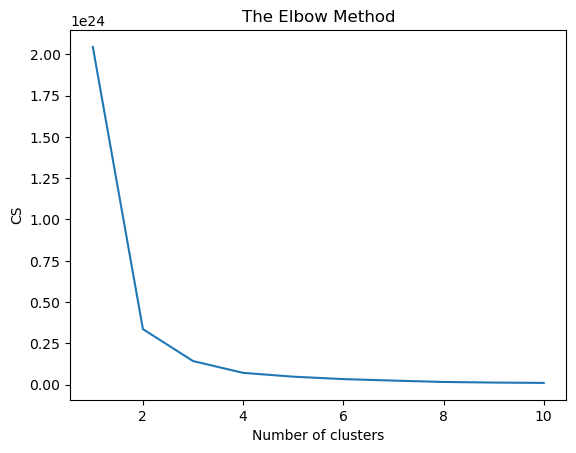

In [162]:
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(AGG_df2)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

### Train Model

In [163]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=1)

kmeans.fit(AGG_df2)

AGG_df2['CLUSTER'] = kmeans.labels_

c:\Users\dell\miniconda\envs\em_bootcathon_env\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


In [156]:
AGG_df2.head(10)

,UserId,SUM_VOLUME,MEAN_POINTS,SUM_POINTS,SUM_QUANTITY,MAX_LEADDAY,MIN_LEADDAY,MEAN_LEADDAY,CLUSTER
0,1569867483497,24,53.75,215,4,9.00,0.00,5.00,0
1,1569928027697,150,35.20,880,25,5.00,0.00,1.12,0
2,1569941239614,180,47.64,1715,36,3.00,0.00,0.78,0
3,1570017799372,564,39.05,3710,95,2.00,0.00,0.32,0
4,1570020582508,30,35.00,175,5,11.00,0.00,4.20,0
5,1570020980989,25,31.25,125,4,6.00,1.00,3.25,0
6,1570023003748,164,37.59,1015,27,6.00,0.00,1.04,0
7,1570024989612,306,14.77,650,44,3.00,0.00,0.66,0
8,1570027636018,1230,36.61,7175,196,1.00,0.00,0.15,0
9,1570030703175,115,29.72,535,18,9.00,0.00,1.22,0


### Result

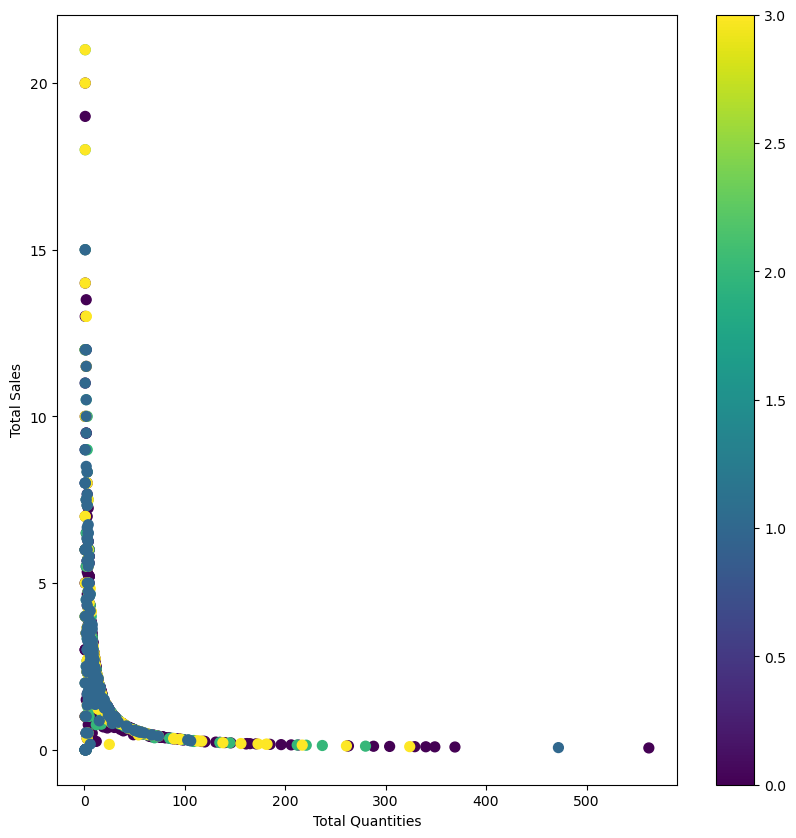

In [164]:
x = AGG_df2['SUM_QUANTITY']
y = AGG_df2['MEAN_LEADDAY']
Cluster = AGG_df2['CLUSTER']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

scatter = ax.scatter(x,y,c=Cluster,s=50)
ax.set_xlabel('Total Quantities')
ax.set_ylabel('Total Sales')
plt.colorbar(scatter)

#fig.savefig('ClusterSales.png', bbox_inches='tight')
#fig.show()

In [ ]:
x = AGG_df2['TOTAL_ORDERS']
y = AGG_df2['MEAN_LeadDay']
Cluster = AGG_df2['CLUSTER']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

scatter = ax.scatter(x,y,c=Cluster,s=50)
ax.set_xlabel('Total Orders')
ax.set_ylabel('Average Lead Days')
plt.colorbar(scatter)

#fig.savefig('ClusterOrders.png', bbox_inches='tight')
#fig.show()

KeyError: 'TOTAL_ORDERS'

## Download Data

In [ ]:
#Create output folder if not exist
if not os.path.exists("output"):
    os.makedirs("output")

data_dir = "output"

#Download modeled data into output folder
AGG_df2.to_csv(f"{data_dir}/Lab1-2.csv")